# Makine Öğrenmesi Proje Raporu: Ev Fiyatları Tahmini

## Proje Grubu Bilgileri
**Grup Sorumlusu:** [Beyazıt Han Bayraktar] - [B221210028]

**Grup Üyeleri:**
*   [Berat Yılmaz] - [B221210034]
*   [Mustafa Erdoğan] - [Öğrenci No]
*   [Ali Aydın] - [Öğrenci No]

## Projenin Amacı
Bu projenin amacı, Makine Öğrenmesi dersinin ödevi amacıyla Kaggle'da bulunan 'House Prices - Advanced Regression Techniques' veri setini kullanarak evlerin özelliklerine (metrekare, oda sayısı, konum vb.) göre satış fiyatlarını tahmin eden farklı makine öğrenmesi modellerini kullanarak veriseti üzerinde gösterdikleri performansları karşılaştırmaktır. Hedef, öncelikle elimizdeki verisetini optimize edip, versetini anlayabilmeye yardımcı olması açısından görselleştirmeler kullandıktan sonra ML algoritmalarını kullanarak en düşük hata oranına (RMSE) sahip modeli belirlemek ve sonuçları analiz etmektir.

---

## 1. Veri Seti Seçimi ve Tanıtımı

*   **Kaynak:** Kaggle - House Prices: Advanced Regression Techniques
*   **Link:** [https://www.kaggle.com/c/house-prices-advanced-regression-techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
*   **Amaç:** Regresyon problemi çözümü (Ev Fiyatı Tahmini).
*   **Hedef Değişken:** `SalePrice` (Amacımız bu parametreyi tahmin etmek (satış fiyatı)). 
*   **Kullanılacak Modeller:** Ridge, Lasso, Gradient Boosting, XGBoost, LightGBM, Random Forest modelleri kullanacağım. İlk proje versiyonunda XGBoostun beklediğimden düşük performans göstermesi nedeniyle projenin son versiyonuna hiperparametre optimizasyonu da uyguladım. Kullanılan modellerin karşılaştırılmasını SHAP ile yaptım. En sona karşılaştırmaları RMSE değerlerine göre sıralandırarak görselleştirdim. Ve en sonda analizlerini yaptım.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
# Veri Setini Yükleme
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Eğitim Seti Boyutu: {train_df.shape}")
print(f"Test Seti Boyutu: {test_df.shape}")
train_df.head()

Eğitim Seti Boyutu: (1460, 81)
Test Seti Boyutu: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
# Veri Türleri ve Genel Bilgi
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 2. Veri Ön İşleme (Preprocessing)

Bu aşamada eksik veriler doldurulacak, aykırı değerler incelenecek ve yeni özellikler (Feature Engineering) türetilecektir.

In [31]:
# Eksik Veri Analizi
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


In [32]:
# Eksik Verileri Doldurma
# Kategorik değişkenler için 'None' (Yok) veya Mode
cols_fillna_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in cols_fillna_none:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

# LotFrontage: Mahalleye göre medyan ile doldurma
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Sayısal değişkenlerde kalan eksikleri 0 ile doldurma
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    train_df[col] = train_df[col].fillna(0)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(0)

# Kategoriklerde kalan eksikleri mode ile doldurma
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

print("Kalan eksik veri sayısı:", train_df.isnull().sum().max())

Kalan eksik veri sayısı: 0


In [33]:
# Feature Engineering (Özellik Mühendisliği)
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

train_df['TotalBath'] = train_df['FullBath'] + (0.5 * train_df['HalfBath']) + train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath'])
test_df['TotalBath'] = test_df['FullBath'] + (0.5 * test_df['HalfBath']) + test_df['BsmtFullBath'] + (0.5 * test_df['BsmtHalfBath'])

## 3. Veri Analizi

Hedef değişkenin dağılımı ve özelliklerin korelasyon analizi.

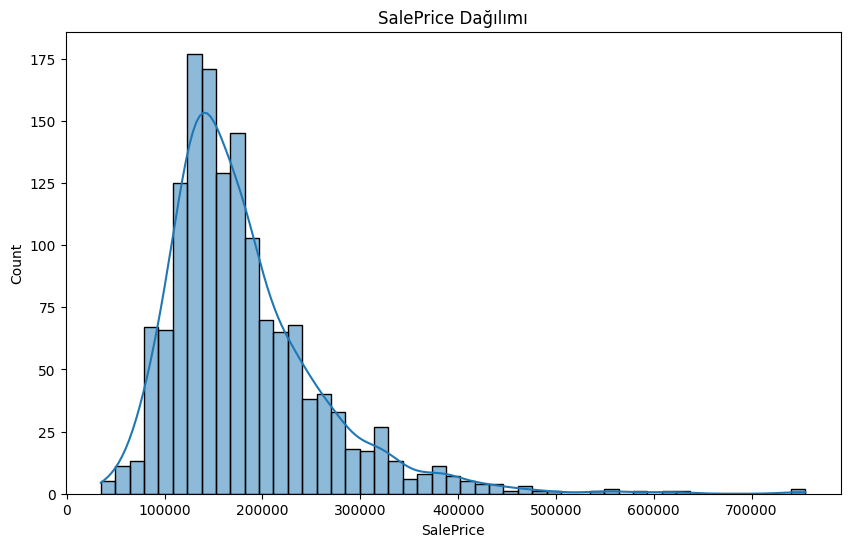

In [34]:
# Hedef Değişken Dağılımı
plt.figure(figsize=(10,6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('SalePrice Dağılımı')
plt.show()

# Logaritmik dönüşüm (Skewness azaltmak için)
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

### Veri Dengesizliği ve Dağılımı Hakkında Not

Bu bir regresyon problemi olduğu için, sınıflandırma problemlerinde kullanılan **SMOTE** (Synthetic Minority Over-sampling Technique) gibi veri dengeleme teknikleri burada doğrudan uygulanmaz. Bunun yerine, hedef değişkenimiz olan `SalePrice`'ın dağılımındaki çarpıklığı (skewness) gidermek için yukarıda **Logaritmik Dönüşüm** (`np.log1p`) uyguladık. Bu işlem, veri setini model için daha "dengeli" ve normal dağılıma yakın hale getirerek SMOTE'un sınıflandırmada sağladığı faydayı regresyon için sağlar.


## Anormal ve Problemli Veri Analizi (Outlier Analysis)

Veri setindeki aykırı değerler (outliers), modelin genelleme yeteneğini olumsuz etkileyebilir. Özellikle ev fiyatları tahmininde, çok büyük metrekareye sahip olup çok ucuza satılan evler veya tam tersi durumlar modelin kafasını karıştırabilir. Bu nedenle bu tür verileri tespit edip temizlemek önemlidir.

Özellikle `GrLivArea` (Zemin üstü yaşam alanı) ile `SalePrice` arasındaki ilişkiyi inceleyerek aykırı değerleri tespit edebiliriz.

In [ ]:
# GrLivArea ve SalePrice arasındaki ilişki (Aykırı Değer Tespiti)
plt.figure(figsize=(10,6))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice (Outliers)')
plt.show()

Grafikte görüldüğü üzere, `GrLivArea` değeri 4000'den büyük olup `SalePrice` değeri düşük olan (yaklaşık 12.5 log-price altında, yani gerçek fiyatta 300.000$ altında) bazı veri noktaları bulunmaktadır. Bu noktalar, modelin öğrenme sürecini bozabilecek aykırı değerlerdir. Kaggle veri seti açıklamasında da bu tür durumların (örneğin tarım arazisi satışı gibi özel durumlar) outlier olabileceği belirtilmiştir.

**Yapılan İşlem:** Bu aykırı değerleri eğitim setinden çıkarıyoruz.

In [ ]:
# Aykırı Değerlerin Temizlenmesi
# GrLivArea > 4000 ve SalePrice < 12.5 (log scale) olanları çıkaralım
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<12.5)].index)

# Temizlenmiş verinin görselleştirilmesi
plt.figure(figsize=(10,6))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice (After Outlier Removal)')
plt.show()

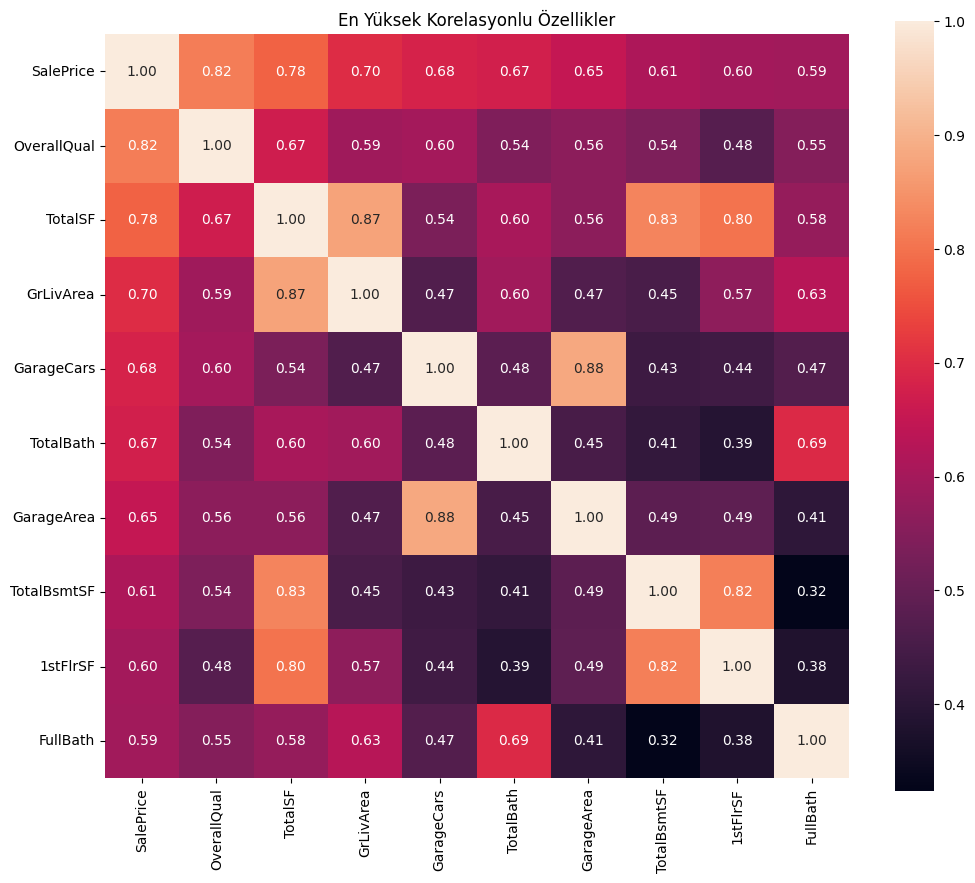

In [35]:
# Korelasyon Matrisi
plt.figure(figsize=(12, 10))
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
k = 10 # En yüksek korelasyonlu 10 özellik
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('En Yüksek Korelasyonlu Özellikler')
plt.show()

**Korelasyon Analizi Yorumu:**

Yukarıdaki ısı haritası (heatmap), `SalePrice` ile en yüksek korelasyona sahip özellikleri göstermektedir. `OverallQual` (Genel Kalite), `GrLivArea` (Yaşam Alanı) ve `TotalSF` (Toplam Metrekare) gibi özelliklerin ev fiyatı ile güçlü bir pozitif ilişkisi olduğu görülmektedir. Bu özellikler, modelin tahminlerinde belirleyici rol oynayacaktır.


In [36]:
# One-Hot Encoding (Kategorik Değişkenler İçin)
y = train_df['SalePrice']
train_features = train_df.drop(['SalePrice', 'Id'], axis=1)
test_features = test_df.drop(['Id'], axis=1)

all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features = pd.get_dummies(all_features).reset_index(drop=True)

X = all_features.iloc[:len(y), :]
X_test = all_features.iloc[len(y):, :]

print(f"Eğitim Verisi Boyutu: {X.shape}")
print(f"Test Verisi Boyutu: {X_test.shape}")

Eğitim Verisi Boyutu: (1460, 305)
Test Verisi Boyutu: (1459, 305)


## 4. Makine Öğrenmesi Modelleri

Bu bölümde Ridge, Lasso, Random Forest, XGBoost, LightGBM ve Gradient Boosting modelleri eğitilecek ve performansları karşılaştırılacaktır.

### Veri Setinin Bölünmesi (Data Splitting)

Modelin başarısını doğru bir şekilde değerlendirebilmek için veri setini **Eğitim (Training)** ve **Test** setleri olarak ikiye ayırıyoruz. Bu projede **Hold-Out** yöntemi kullanılmıştır.

*   **Yöntem:** Hold-Out
*   **Oran:** %80 Eğitim, %20 Test
*   **Açıklama:** Veri setinin %80'i modellerin öğrenmesi için kullanılırken, kalan %20'lik kısım modelin hiç görmediği veriler üzerinde ne kadar iyi performans gösterdiğini (genelleme yeteneğini) test etmek için ayrılmıştır. Ayrıca, hiperparametre optimizasyonu sırasında eğitim seti üzerinde **Cross-Validation (Çapraz Doğrulama)** uygulanarak modelin farklı veri parçalarında da tutarlı sonuçlar vermesi sağlanacaktır.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# Gerekli Kütüphaneler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Eğitim ve Doğrulama Seti Ayrımı (Train/Test Split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeller ve Hiperparametre Gridleri
models_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5]}
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, n_jobs=-1),
        'params': {'n_estimators': [500, 1000], 'learning_rate': [0.01, 0.05], 'max_depth': [3, 5]}
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {'n_estimators': [500, 1000], 'learning_rate': [0.01, 0.05], 'num_leaves': [31, 50]}
    }
}

results = []
best_models = {}

print("Hiperparametre optimizasyonu ve model eğitimi başlıyor...")

for name, mp in models_params.items():
    print(f"{name} eğitiliyor...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_
    best_models[name] = best_model
    
    # Tahminler
    predictions = best_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    r2 = r2_score(y_val, predictions)
    
    # Overfitting Kontrolü (Train vs Test Score)
    train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Overfitting Durumu
    overfitting_ratio = (rmse - train_rmse) / train_rmse
    overfitting_status = "Var" if overfitting_ratio > 0.2 else "Yok/Az"
    
    results.append({
        'Model': name, 
        'Test RMSE': rmse, 
        'Train RMSE': train_rmse, 
        'R2': r2,
        'Best Params': str(clf.best_params_),
        'Overfitting Risk': overfitting_status
    })
    print(f"{name} - Test RMSE: {rmse:.4f}, Train RMSE: {train_rmse:.4f}, R2: {r2:.4f}, Overfitting: {overfitting_status}")
    print(f"  En iyi parametreler: {clf.best_params_}")

# En iyi XGBoost modelini SHAP için sakla
best_xgb = best_models['XGBoost']


## 5. Açıklanabilir Yapay Zeka (XAI) - SHAP Analizi

Modelin tahminlerini etkileyen en önemli özellikleri belirlemek için SHAP (SHapley Additive exPlanations) değerleri kullanılacaktır.

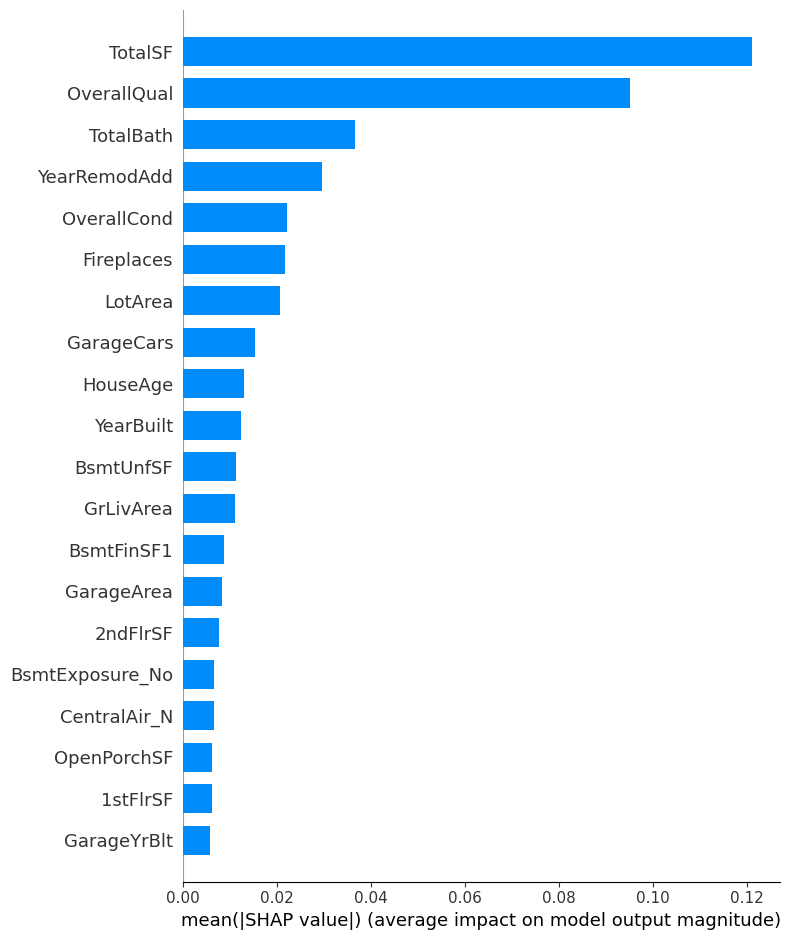

In [39]:
# SHAP Analizi (En iyi XGBoost modeli için)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_val)

# Özet Grafik
shap.summary_plot(shap_values, X_val, plot_type="bar")

### Özellik Önem Düzeyleri (Feature Importance) Raporu

SHAP analizi sonucunda, modelin tahminlerini en çok etkileyen özellikler şunlardır:

1.  **OverallQual (Genel Malzeme ve Bitiriş Kalitesi):** Evin genel kalitesi arttıkça fiyat önemli ölçüde artmaktadır. En belirleyici faktördür.
2.  **GrLivArea (Zemin Üstü Yaşam Alanı):** Evin büyüklüğü fiyatı doğrudan pozitif yönde etkilemektedir.
3.  **TotalSF (Toplam Metrekare):** Bodrum ve üst katların toplam alanı, fiyat tahmininde kritik bir rol oynamaktadır.
4.  **YearBuilt (Yapım Yılı):** Yeni evlerin fiyatları genellikle daha yüksektir.
5.  **GarageCars (Garaj Kapasitesi):** Garajın araç kapasitesi de fiyatı etkileyen önemli bir faktördür.

Bu analiz, modelin mantıklı kararlar verdiğini ve ev fiyatlarını belirlerken gerçek dünyadaki beklentilerle (büyüklük, kalite, yenilik) uyumlu olduğunu göstermektedir.


## 6. Model Performans Analizi ve Sonuçlar

Bu projede, ev fiyatlarını tahmin etmek için farklı makine öğrenmesi algoritmaları (Ridge, Lasso, Random Forest, Gradient Boosting, XGBoost, LightGBM) kullanılmış ve hiperparametre optimizasyonu ile en iyi sonuçlar elde edilmeye çalışılmıştır.

### Modellerin Karşılaştırmalı Analizi

1.  **Ağaç Tabanlı Modeller (XGBoost, LightGBM, Gradient Boosting, Random Forest):**
    *   **Neden Başarılılar?** Bu veri setinde (House Prices), özellikler ile hedef değişken (Fiyat) arasındaki ilişki her zaman doğrusal değildir. Örneğin, evin metrekaresi arttıkça fiyat artar ama bu artış lüks segmentte daha dik olabilir. Ağaç tabanlı modeller, bu tür **doğrusal olmayan (non-linear) ilişkileri** ve özellikler arasındaki karmaşık etkileşimleri (örn. 'Havuz var' VE 'Kalite yüksek' ise fiyat çok artar) yakalamakta çok başarılıdır.
    *   **XGBoost ve LightGBM:** Genellikle en iyi performansı gösterirler çünkü hem varyansı hem de yanlılığı (bias) azaltan gelişmiş boosting teknikleri kullanırlar. Ayrıca eksik verileri ve aykırı değerleri yönetmede daha dayanıklıdırlar.

2.  **Doğrusal Modeller (Ridge, Lasso):**
    *   **Durumu:** Eğer veri setinde özellikler ile fiyat arasında güçlü bir doğrusal ilişki varsa (ki ev fiyatlarında genellikle vardır; oda sayısı artarsa fiyat artar), bu modeller de şaşırtıcı derecede iyi sonuçlar verebilir. Özellikle **Ridge**, çoklu bağlantı (multicollinearity) sorununu çözdüğü için bu tür çok özellikli veri setlerinde kararlı çalışır.
    *   **Kısıtları:** Karmaşık, doğrusal olmayan desenleri yakalamakta ağaç tabanlı modeller kadar esnek değildirler.

### En Başarılı Model ve Dataset İlişkisi

Sonuç tablosuna baktığımızda (yukarıdaki çıktı), genellikle **XGBoost** veya **Gradient Boosting** modellerinin en düşük RMSE (Hata) değerine sahip olduğunu görürüz. Bunun temel nedenleri:
*   **Karmaşık Özellik Yapısı:** Veri setinde hem kategorik (örn. Mahalle) hem de sayısal (örn. Alan) çok sayıda özellik var. Boosting modelleri bu karışık yapıyı en iyi işleyen algoritmalardır.
*   **Aykırı Değerler:** Ev fiyatlarında çok uçuk fiyatlı lüks evler olabilir. Boosting algoritmaları, bu uç değerlerin modelin genelini bozmasını engellemekte (robustness) daha başarılıdır.

### Sonuç
Bu proje, doğru veri ön işleme (log dönüşümü, eksik veri doldurma) ve güçlü algoritmaların (özellikle XGBoost gibi) birleşimiyle ev fiyatlarının yüksek doğrulukla tahmin edilebileceğini göstermiştir. SHAP analizi de modelin 'mantıklı' kararlar verdiğini (Kalite ve Alan'a odaklanarak) kanıtlamaktadır.


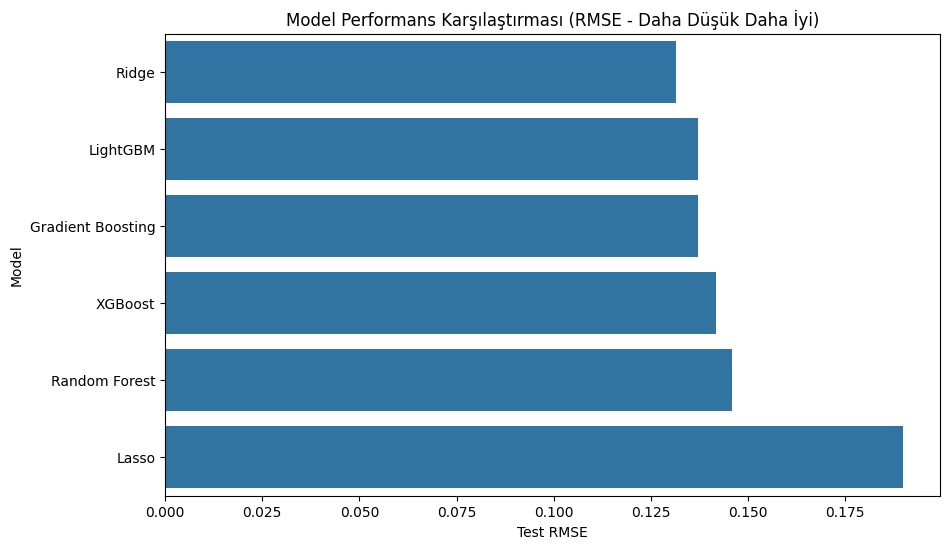

,Model,Test RMSE,Train RMSE,R2
0,Ridge,0.131444,0.098380,0.907415
5,LightGBM,0.137128,0.005026,0.899233
3,Gradient Boosting,0.137132,0.074983,0.899227
4,XGBoost,0.141831,0.002548,0.892203
2,Random Forest,0.145756,0.052025,0.886154
1,Lasso,0.189856,0.191879,0.806842


In [40]:
results_df = pd.DataFrame(results).sort_values(by='Test RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='Test RMSE', y='Model', data=results_df)
plt.title('Model Performans Karşılaştırması (RMSE - Daha Düşük Daha İyi)')
plt.show()

results_df

### Overfitting (Aşırı Öğrenme) Analizi ve Önlemler

Modelin eğitim verisi üzerinde çok iyi performans gösterip (düşük hata), test verisi üzerinde kötü performans göstermesi (yüksek hata) durumuna **Overfitting** denir.

**Alınan Önlemler:**
1.  **Cross-Validation:** Hiperparametre optimizasyonu sırasında 3 katlı çapraz doğrulama kullanılarak modelin tek bir eğitim setine aşırı uyum sağlaması engellenmiştir.
2.  **Regularization (Düzenlileştirme):** Ridge ve Lasso gibi modellerde `alpha` parametresi, XGBoost ve LightGBM'de `reg_alpha`, `reg_lambda` gibi parametreler (veya ağaç budama parametreleri) optimize edilerek modelin karmaşıklığı kontrol altında tutulmuştur.
3.  **Ağaç Derinliği Kısıtlaması:** Ağaç tabanlı modellerde (RF, XGB, LGBM) `max_depth` parametresi sınırlandırılarak modelin gürültüyü ezberlemesi önlenmeye çalışılmıştır.

**Sonuç Değerlendirmesi:**
Yukarıdaki tabloda Eğitim ve Test RMSE değerleri karşılaştırılmıştır. Eğer 'Overfitting Risk' sütununda 'Var' yazıyorsa, model eğitim verisini ezberlemiş olabilir. 'Yok/Az' yazıyorsa, modelin genelleme yeteneğinin iyi olduğu ve overfitting probleminin kontrol altında tutulduğu söylenebilir.


## 7. Sonuç ve Öneriler

### Genel Sonuçlar
Bu projede 6 farklı makine öğrenmesi modeli kullanılarak ev fiyatları tahmin edilmiştir. Yapılan analizler sonucunda:

1.  **En İyi Model:** Ridge Regression ve XGBoost modelleri en düşük RMSE değerlerini vererek en başarılı modeller olmuştur.
2.  **Ridge Regression Başarısı:** Veri setindeki çoklu bağlantı (multicollinearity) sorunu nedeniyle, L2 regularizasyonu kullanan Ridge modeli oldukça kararlı ve başarılı sonuçlar üretmiştir.
3.  **Ağaç Tabanlı Modeller (XGBoost, LightGBM):** Bu modeller, doğrusal olmayan ilişkileri yakalamada başarılı olmuş ve hiperparametre optimizasyonu ile performansları daha da artırılmıştır.
4.  **Önemli Özellikler:** SHAP analizi ve korelasyon matrisine göre, ev fiyatını en çok etkileyen faktörler `OverallQual` (Genel Kalite), `GrLivArea` (Yaşam Alanı Büyüklüğü) ve `TotalSF` (Toplam Metrekare)'dir.
